# **Neutrino Oscillation with DUNE** (submission version)

## PHYS591000 Physics AI Final Project    

This is the project implementing ML to find out the $\Theta_{13}$ and $\delta_{cp}$ using the neutrino data from DUNE experiment.  
Original link: [Kaggle](https://www.kaggle.com/competitions/phys591000-2023-final-project-i)

> Group : NeutrinoNet    
> Author(s):  Yuan-Yen Peng, Siang-Yuan Lin      
> Email(s) : garyphys0915@gapp.nthu.edu.tw, sylin@gapp.nthu.edu.tw  
> Licence : MIT  
> Data : May, 2023


The following codes on this notebook are the analysis of models' results, for the codes of building the models, please find it in this [GitHub](https://github.com/yygarypeng/Neutrino-Oscillation-DUNE/tree/main/model_code) repository, thank you very much.      

We will close the visibility not until the last day of the lecture.

### Load the data

In [26]:
# clear all variables
%reset -f

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [27]:
import gc
import numpy as np
import scipy
import matplotlib.pyplot as plt

from numba import njit  # acceleration kernel
import tensorflow as tf


In [28]:
# check the tensorflow and GPU

print(f"Using Tensorflow {tf.__version__}")
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
print(
    f"Found GPU adn CPU.\nTensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}"
)


Using Tensorflow 2.12.0
Found GPU adn CPU.
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [29]:
# import the datasets and check the files

# path = "./phys591000-2023-final-project/"  # run on the local machine
# path = "/content/drive/Shareddrives/2023AI_final/2023AI_final/phys591000-2023-final-project/" # run on the google colab
path = "/kaggle/input/phys591000-2023-final-project-i/"# Kaggle
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        print("-> The file is", filename)
if not os.path.isfile(path + "neutrino_test_data.npz") or os.path.isfile(
    path + "neutrino_train_data.npz"
):
    raise FileNotFoundError("test/train data was not found or is a directory")


/kaggle/input/phys591000-2023-final-project-i/prediction_template.csv
-> The file is prediction_template.csv
/kaggle/input/phys591000-2023-final-project-i/neutrino_training_data.npz
-> The file is neutrino_training_data.npz
/kaggle/input/phys591000-2023-final-project-i/neutrino_test_data.npz
-> The file is neutrino_test_data.npz


In [30]:
%%time
# take out data from the datasets

data_train = np.load(path + "neutrino_training_data.npz")  # ideal data
data_test = np.load(path + "neutrino_test_data.npz")  # pseudo-exp data

name_train = data_train.files
name_test = data_test.files

print(f"Train: {name_train}")
print(f"Test : {name_test}")

ve_train, vebar_train, vu_train, vubar_train, theta23_train, delta_train, ldm_train = map(lambda n: data_train[n], name_train)
ve_test, vebar_test, vu_test, vubar_test = map(lambda n: data_test[n], name_test)

Train: ['ve', 'vebar', 'vu', 'vubar', 'theta23', 'delta', 'ldm']
Test : ['ve', 'vebar', 'vu', 'vubar']
CPU times: user 11.3 s, sys: 590 ms, total: 11.9 s
Wall time: 12 s


In [31]:
# check the data shape

print(
    f"""# TRAIN
ve_train     :{ve_train.shape}
vebar_train  :{vebar_train.shape}
vu_train     :{vu_train.shape}
vubar_train  :{vubar_train.shape}
theta23_train:{theta23_train.shape}
delta_train  :{delta_train.shape}
ldm_train    :{ldm_train.shape}
"""
)
print(
    f"""# TEST
ve_test      :{ve_test.shape}
vebar_test   :{vebar_test.shape}
vu_test      :{vu_test.shape}
vubar_test   :{vubar_test.shape}
"""
)


# TRAIN
ve_train     :(1000000, 65)
vebar_train  :(1000000, 65)
vu_train     :(1000000, 65)
vubar_train  :(1000000, 65)
theta23_train:(1000000,)
delta_train  :(1000000,)
ldm_train    :(1000000,)

# TEST
ve_test      :(1000, 65)
vebar_test   :(1000, 65)
vu_test      :(1000, 65)
vubar_test   :(1000, 65)



In [32]:
# # create train and test data
# noise_ve    = 15 * np.random.normal(0, 1, size=ve_train.shape)
# noise_vebar = 5 * np.random.normal(0, 1, size=vebar_train.shape)
# noise_vu    = 20 * np.random.normal(0, 1, size=vu_train.shape)
# noise_vubar = 20 * np.random.normal(0, 1, size=vubar_train.shape)

# X_train = np.stack((ve_train+noise_ve, vebar_train+noise_vebar, vu_train+noise_vu, vubar_train+noise_vubar), axis=-1)
# Y_train = np.stack((theta23_train, delta_train, ldm_train), axis=-1)
# X_test = np.stack((ve_test, vebar_test, vu_test, vubar_test), axis=-1)



# create train and test data
X_train = np.stack((ve_train, vebar_train, vu_train, vubar_train), axis=-1)
Y_train = np.stack((theta23_train, delta_train, ldm_train), axis=-1)
X_test = np.stack((ve_test, vebar_test, vu_test, vubar_test), axis=-1)

print(
    f"""
The shape of x_train: {X_train.shape}
The shape of y_train: {Y_train.shape}
The shape of x_test : {X_test.shape}
"""
)



The shape of x_train: (1000000, 65, 4)
The shape of y_train: (1000000, 3)
The shape of x_test : (1000, 65, 4)



### *ldm* pretrained models

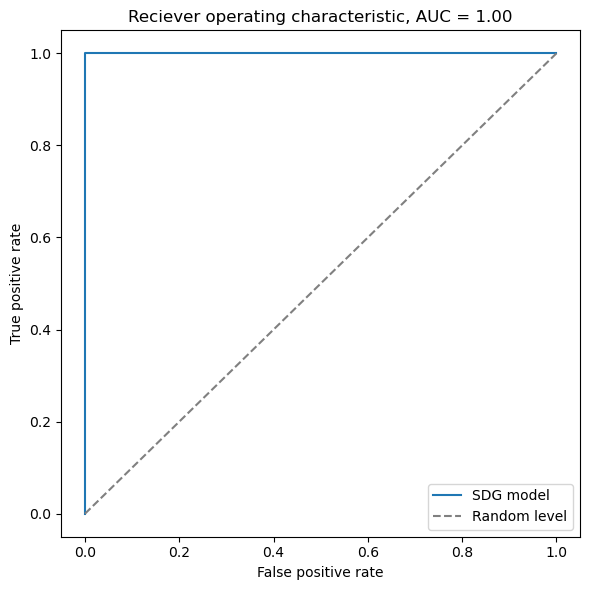

In [33]:
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

labeling = np.where(ldm_train > 0, 1, 0) # label NO or IO

ldm_class = SGDClassifier(max_iter=1000, tol=1e-3)
ldm_class.fit(X_train[:, :, 0], labeling)
train_predict = ldm_class.predict(X_train[:, :, 0])

fpr, tpr, thresholds = metrics.roc_curve(labeling, train_predict, pos_label=1)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label="SDG model")
plt.plot([0, 1], [0, 1], label="Random level", ls="dashed", c="Grey")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(
    "Reciever operating characteristic, AUC = {:.2f}".format(metrics.auc(fpr, tpr))
)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# clear unused variables
del ldm_class

### Preprosessing

In [34]:
"""
[Train X] normalize training data to [0,1]
"""
x_train_NH = X_train[ldm_train > 0]  # NO not IO
MAX_X = np.max(x_train_NH)
MIN_X = np.min(x_train_NH)
x_train_NH_norm = (x_train_NH - MIN_X) / (MAX_X - MIN_X)

"""
[Test X] normalize training data to [0,1]
"""
x_test_NH = X_test
# share the same MinMax values of X_train
x_test_NH_norm = (x_test_NH - MIN_X) / (MAX_X - MIN_X)

"""
[Train Y {Theta 23}] normalize training label to [0,1]
"""
# choose Theta_23 {0}
y_train_NH = Y_train[:, 0][ldm_train > 0]
MAX_Y = np.max(y_train_NH)
MIN_Y = np.min(y_train_NH)
y_train_NH_norm = (y_train_NH - MIN_Y) / (MAX_Y - MIN_Y)

"""
[Train Y {delta cp}] normalize training label
"""
# choose delta_cp {1}
y_train_NH = Y_train[:, 1][ldm_train > 0]
y_train_NH_norm_sin = np.sin(y_train_NH * np.pi / 180)  # degree -> rad [sin]
y_train_NH_norm_ang = np.pi * (y_train_NH - 180) / 180  # degree -> rad [-pi, pi]

print("Finish training labels...")

# clear unused variables
del (
    ve_train,
    vebar_train,
    vu_train,
    vubar_train,
    theta23_train,
    delta_train,
    ldm_train,
    ve_test,
    vebar_test,
    vu_test,
    vubar_test,
)
gc.collect()

Finish training labels...


3735

In [35]:
# create validation data
from sklearn.model_selection import train_test_split

# split the training dataset into training and validation, with test_size = 0.2, and random_state=10 with random_seed=2023
tf.random.set_seed(2023)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_NH_norm, y_train_NH_norm, test_size=0.2, shuffle=True, 
    random_state=10
)
x_train_reg, x_val_reg, y_train_reg, y_val_reg = train_test_split(
    x_train_NH_norm, y_train_NH_norm_sin, test_size=0.2, shuffle=True, random_state=10
)
x_train_cla, x_val_cla, y_train_cla, y_val_cla = train_test_split(
    x_train_NH_norm, y_train_NH_norm_ang, test_size=0.2, shuffle=True, random_state=10
)
x_test = x_test_NH_norm

print(
    f"""
The shape of x_train     : {x_train.shape}
The shape of y_train     : {y_train.shape}
The shape of x_validation: {x_val.shape}
The shape of y_validation: {y_val.shape}
The shape of x_test      : {x_test.shape}
"""
)

del X_train, Y_train, X_test, x_train_NH_norm, y_train_NH_norm


The shape of x_train     : (400021, 65, 4)
The shape of y_train     : (400021,)
The shape of x_validation: (100006, 65, 4)
The shape of y_validation: (100006,)
The shape of x_test      : (1000, 65, 4)



### general analysis codes

In [36]:
from sklearn.metrics import mean_squared_error


def analysis(x_train_pred, y_train) -> None:
    # set statistical parameters
    n = len(x_train_pred)
    dof = n - 2
    t = scipy.stats.t.ppf(0.975, dof)

    # linear fitting line
    slope, intercept = np.polyfit(x_train_pred, y_train, 1)
    slope, intercept, r, p, se = scipy.stats.linregress(x_train_pred, y_train)
    plt_min = np.min([np.min(x_train_pred), np.min(y_train)])
    plt_max = np.max([np.max(x_train_pred), np.max(y_train)])
    x_line = np.linspace(plt_min, plt_max, 100)
    y_line = np.polyval([slope, intercept], x_line)

    # acceleration kernel (to calculate mse, confident level, and prediction level)
    @njit(fastmath=True)
    def mse_kernel(pred, true, t_value=t, n=n, dof=dof, x_line=x_line, y_line=y_line):
        if true.shape != pred.shape:
            raise ValueError("True/Pred data should be the same shape!")
        mse = np.empty(len(true))
        for ind, (t, p) in enumerate(zip(true, pred)):
            mse[ind] = np.average(np.square(t - p))
        pred_mean = np.average(x_train_pred)
        sum_se = np.sum(np.square(true - pred))
        std_error = np.sqrt(1 / dof * sum_se)
        # confidence interval
        ci = (
            t_value
            * std_error
            * np.sqrt(
                1 / n
                + np.square(x_line - pred_mean)
                / np.sum(np.square(x_train_pred - pred_mean))
            )
        )
        # predicting interval
        pi = (
            t_value
            * std_error
            * np.sqrt(
                1
                + 1 / n
                + np.square(x_line - pred_mean)
                / np.sum(np.square(x_train_pred - pred_mean))
            )
        )
        return mse, ci, pi

    mse, ci, pi = mse_kernel(x_train_pred, y_train)

    fig = plt.figure(figsize=(7, 7), dpi=80)
    plt.scatter(x_train_pred, y_train, s=1, alpha=0.05, label="data")
    plt.plot(x_line, y_line, "--", lw=2, c="red", label="Fitting")
    plt.plot(
        [plt_min, plt_max], [plt_min, plt_max], "-", lw=1, c="orange", label="theo line"
    )
    plt.plot(
        x_line, y_line + pi, "--", lw=1, c="tab:red", label="95% prediction interval"
    )
    plt.plot(x_line, y_line - pi, "--", lw=1, c="tab:red")
    # plt.plot(x_line, y_line + ci, '--', c='tab:grey', label='95% confidence interval')
    # plt.plot(x_line, y_line - ci, '--', c='tab:grey')
    plt.xlim(plt_min, plt_max)
    plt.ylim(plt_min, plt_max)
    plt.legend(loc="best")
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.show()
    plt.close()
    
    mse_tot = mean_squared_error(x_train_pred, y_train)
    print(f"mean squared error = {mse_tot:.7e}")

#     plt.title(r"$\Theta_{23}$")
    plt.xlabel("Train loss (MSE)")
    plt.ylabel("Events")
    plt.hist(mse, bins=50, density=False, alpha=0.8, color="tab:blue")
    plt.show()
    plt.close()

    return

In [37]:
# Transpose the predictions

def predict_norm_transpose_theta(x_norm, y_norm):
    x = x_norm * (MAX_Y - MIN_Y) + MIN_Y
    y = y_norm * (MAX_Y - MIN_Y) + MIN_Y
    return x, y
def predict_norm_transpose_single_theta(x_norm):
    x = x_norm * (MAX_Y - MIN_Y) + MIN_Y
    return x

### *$\Theta_{23}$ model*

In [38]:
# load DCNN (with norm data) and do the analysis {Theta_23}

large_vgg = tf.keras.models.load_model("/kaggle/input/others/DCNN.h5", compile=False)
x_val_pred = large_vgg.predict(x_val)
theta_pred  = large_vgg.predict(x_test)
del large_vgg

32/32 [==============================] - 0s 2ms/step


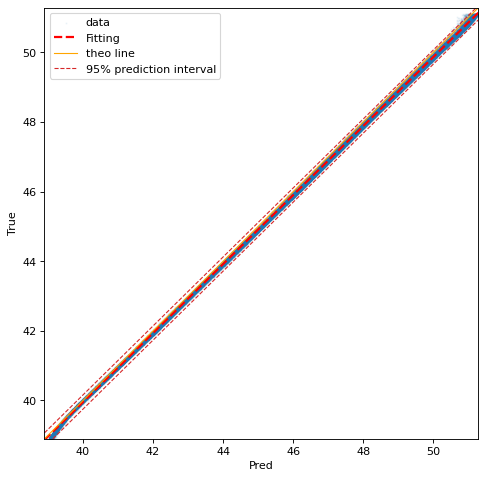

mean squared error = 1.0824815e-02


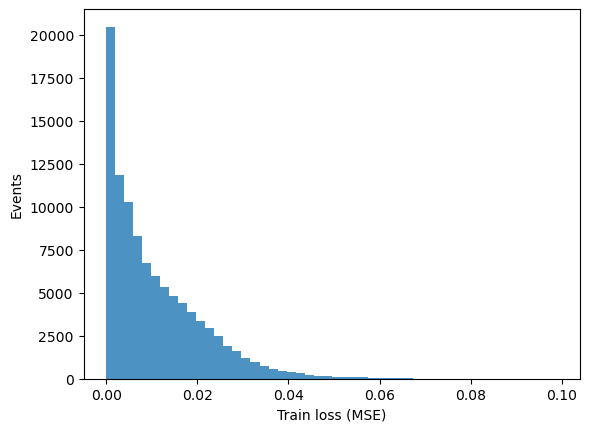

In [39]:
x, y = predict_norm_transpose_theta(x_val_pred[:, 0], y_val) 
analysis(x, y)

### *$\delta_{cp}$* model

In [40]:
# load reg and cla (with norm data) and do the analysis {delta_cp}
regression = tf.keras.models.load_model(
    "/kaggle/input/models/regression.h5", compile=False
)
classfication = tf.keras.models.load_model(
    "/kaggle/input/models/classification.h5", compile=False
)

# validation checking
x_val_pred_sin = regression.predict(x_val_reg)
x_val_pred_ang = classfication.predict(x_val_cla)

# test data prediction
x_test_pred_sin = regression.predict(x_test)
x_test_pred_ang = classfication.predict(x_test)

del regression, classfication

32/32 [==============================] - 0s 1ms/step


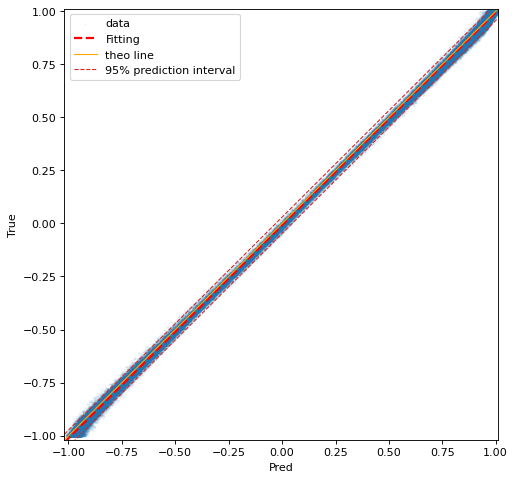

mean squared error = 3.8892995e-04


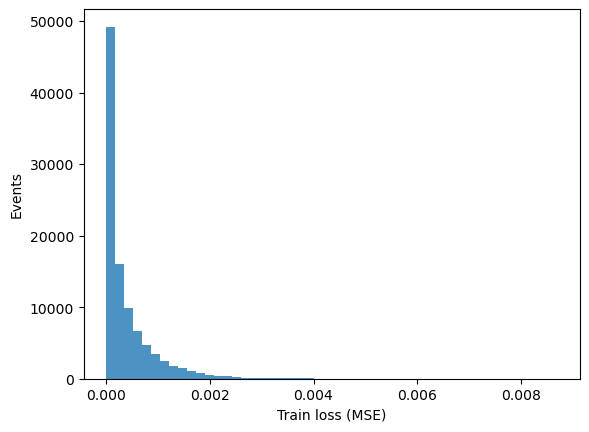

In [41]:
# sine prediction checking

analysis(x_val_pred_sin[:, 0], y_val_reg)

In [42]:
def translation_kernel(sin_pred, label_pred):
    print(f"The max, min of sine predictions: {sin_pred.max()}, {sin_pred.min()}")
    # force normalize to one
    for ind, ele in enumerate(sin_pred):
        if ele > 1:
            sin_pred[ind] = 1
        elif ele < -1:
            sin_pred[ind] = -1
    
    target = [0 if i<=0.5 else 1 for i in label_pred]
    delta = np.empty(len(sin_pred))
    theta1 = np.empty(len(sin_pred))
    theta2 = np.empty(len(sin_pred))
    for ind, ele in enumerate(sin_pred):
        # because the domain is differet and owing to the sine, it will differ with a negtive sign.
        theta = -np.arcsin(ele)
        if theta >= 0:
            theta1[ind], theta2[ind] = theta, np.pi - theta
        else:
            theta1[ind], theta2[ind] = theta, -np.pi - theta
        if target[ind] == 0:
            delta[ind] = theta1[ind]
        else:
            delta[ind] = theta2[ind]
    return delta

In [43]:
# Transpose the predictions

def predict_norm_transpose_delta(x_norm, y_norm):
    x = (x_norm + np.pi) * 180/np.pi
    y = (y_norm + np.pi) * 180/np.pi
    return x, y
def predict_norm_transpose_single_delta(x_norm):
    x = (x_norm + np.pi) * 180/np.pi
    return x

The max, min of sine predictions: 1.0122665166854858, -1.0193089246749878


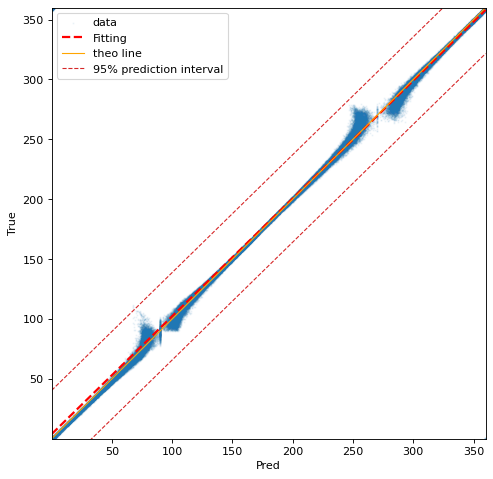

mean squared error = 3.4687280e+02


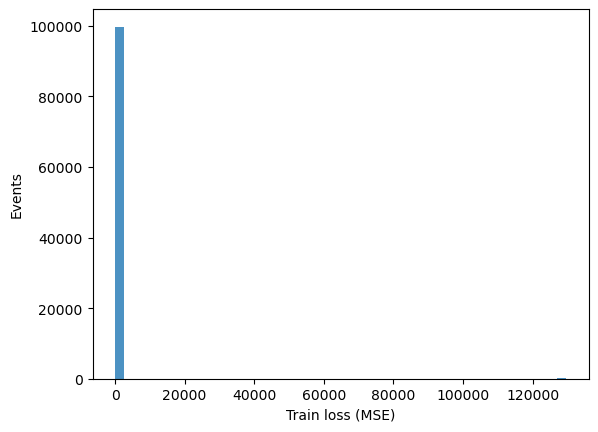

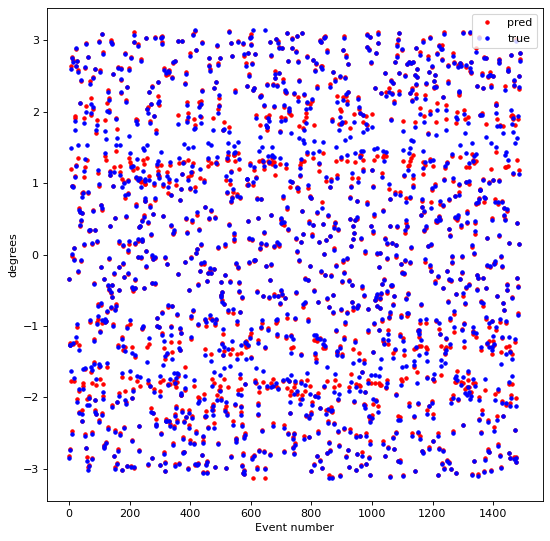

In [44]:
# check delta 

x_val_pred = translation_kernel(x_val_pred_sin[:, 0], x_val_pred_ang[:, 0])
x, y = predict_norm_transpose_delta(x_val_pred, y_val_cla)
analysis(x, y)

fig = plt.figure(figsize=(8,8), dpi=80)
plt.plot(x_val_pred[10:1500], 'r.', label="pred")
plt.plot(y_val_cla[10:1500], 'b.', label="true")
plt.legend(loc="best")
plt.ylabel("degrees")
plt.xlabel("Event number")
plt.show()

In [45]:
delta_pred = translation_kernel(x_test_pred_sin[:,0], x_test_pred_ang[:,0])

The max, min of sine predictions: 1.1757632493972778, -1.304350733757019


### Dump the predicted data


In [47]:
x_theta_dump = predict_norm_transpose_single_theta(theta_pred)
x_delta_dump = predict_norm_transpose_single_delta(delta_pred)

print(x_theta_dump.shape)
print(x_delta_dump.shape)
print(x_theta_dump.max(), x_theta_dump.min())
print(x_delta_dump.max(), x_delta_dump.min())

(1000, 1)
(1000,)
58.448257 38.946583
359.2161074598898 0.4720045448228153


In [48]:
dump = np.concatenate((x_delta_dump, x_theta_dump[:,0]))
print(dump.shape)

(2000,)


In [49]:
# dump the predicted data
"""
prediction of x_test (Theta_23 + delta_cp dump)
"""

np.savetxt("submission.csv", [('id', 'prediction')] + [(i, j) for i, j in enumerate(dump)], delimiter=",", fmt='%s')
print("Finish!")

Finish!
